# Laser Pulse Identification Using Neural Networks

This notebook gives a demonstration of the laser pulse identification algorithm used to locate the peaks of laser pulses from images taken from a streak camera. A neural network is used to identify the number of laser pulses and their general locations, from which the exact locations of the peaks can be found. This algorithm serves as the general proof of concept for a more developed laser pulse detection algorithm with a specific optical build.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from PIL import Image
from scipy import stats
from scipy.signal import find_peaks

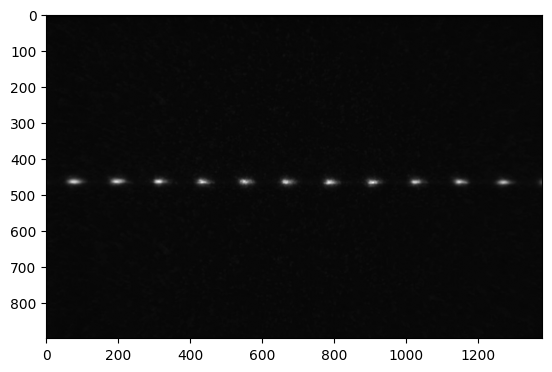

In [2]:
# retrieve the image used for demonstration
pulses = Image.open("laser_pulses.TIF").convert('L')
pulses = np.array(pulses)
# resize
pulses = pulses[:900,:1380]
# plot
plt.imshow(pulses, cmap="grey")

In [3]:
# define the interval spanned by the distribution (0-indexed)
xSpan = np.linspace(0, len(pulses[0])-1, len(pulses[0]))

In [4]:
# split data to train model
train = pulses[:,:690]
test = pulses[:,690:]

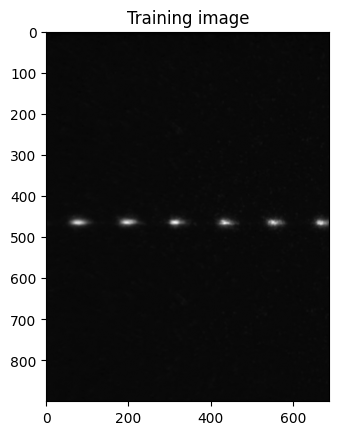

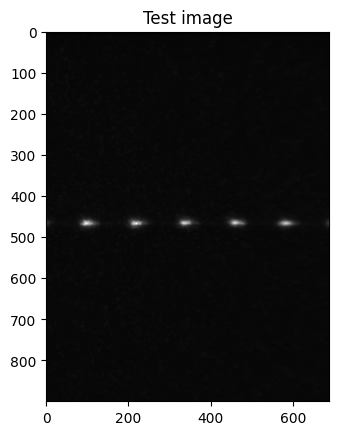

In [5]:
# plot
plt.imshow(train, cmap="grey")
plt.title("Training image")
plt.show()
plt.imshow(test, cmap="grey")
plt.title("Test image")
plt.show()

The images will be split into 30x60 pixel blocks. The blocks that contain pixels will be labeled as such. They will be used to train a neural network classifier to identify laser pulses in an image

In [6]:
# define blocks containing the pulses in training data
pulse1a = train[450:480,30:90]
pulse1b = train[450:480,60:120]
pulse2a = train[450:480,150:210]
pulse2b = train[450:480,180:240]
pulse3a = train[450:480,270:330]
pulse3b = train[450:480,300:360]
pulse4a = train[450:480,390:450]
pulse4b = train[450:480,420:480]
pulse5a = train[450:480,510:570]
pulse5b = train[450:480,540:600]
pulse6 = train[450:480,630:690]

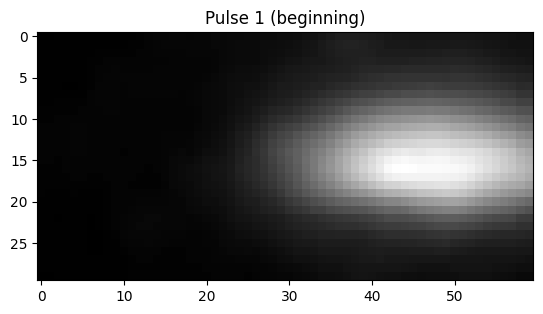

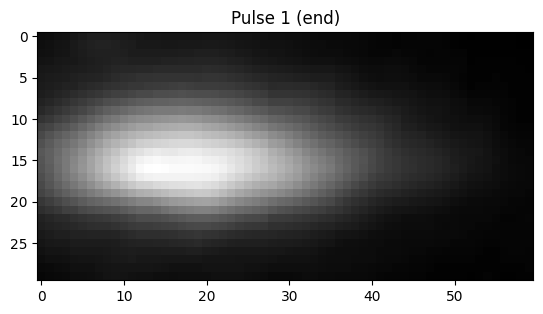

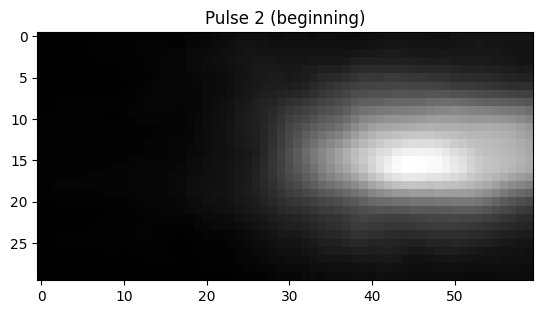

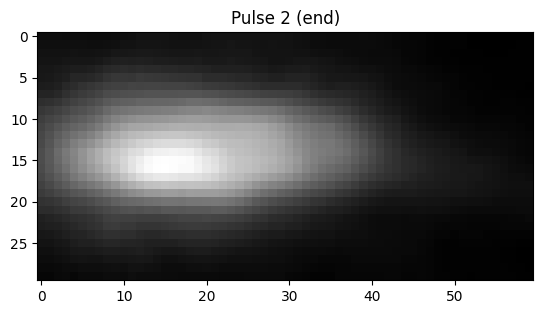

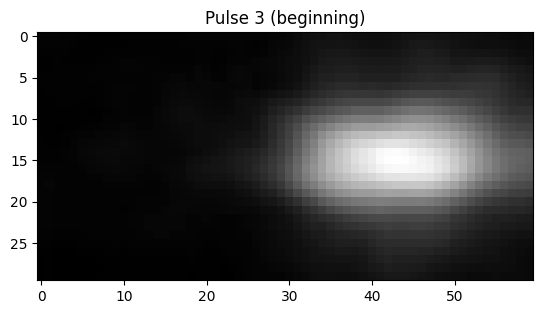

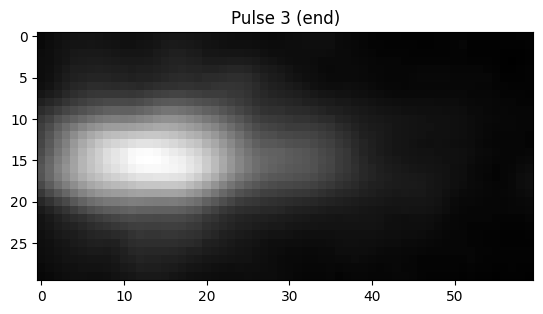

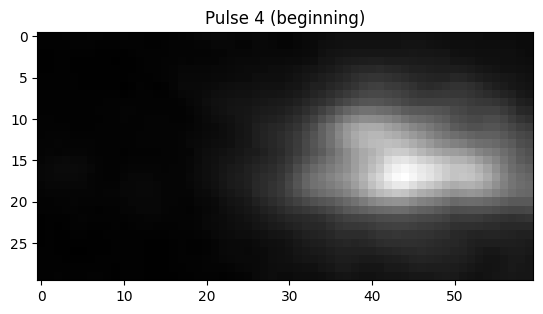

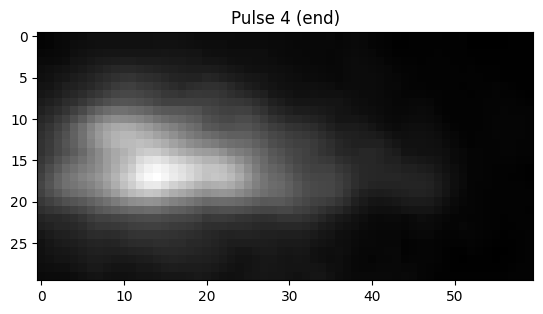

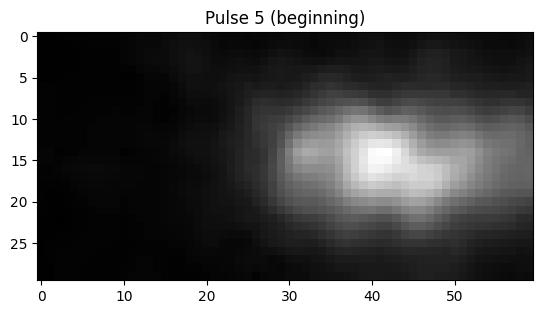

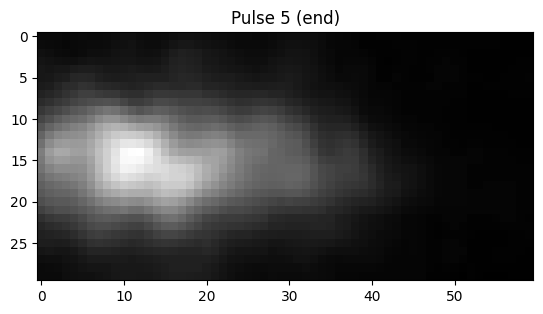

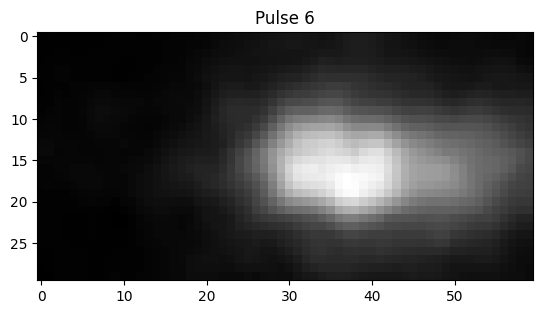

In [7]:
# verify these are the pulses in the image
plt.imshow(pulse1a, cmap="grey")
plt.title("Pulse 1 (beginning)")
plt.show()
plt.imshow(pulse1b, cmap="grey")
plt.title("Pulse 1 (end)")
plt.show()
plt.imshow(pulse2a, cmap="grey")
plt.title("Pulse 2 (beginning)")
plt.show()
plt.imshow(pulse2b, cmap="grey")
plt.title("Pulse 2 (end)")
plt.show()
plt.imshow(pulse3a, cmap="grey")
plt.title("Pulse 3 (beginning)")
plt.show()
plt.imshow(pulse3b, cmap="grey")
plt.title("Pulse 3 (end)")
plt.show()
plt.imshow(pulse4a, cmap="grey")
plt.title("Pulse 4 (beginning)")
plt.show()
plt.imshow(pulse4b, cmap="grey")
plt.title("Pulse 4 (end)")
plt.show()
plt.imshow(pulse5a, cmap="grey")
plt.title("Pulse 5 (beginning)")
plt.show()
plt.imshow(pulse5b, cmap="grey")
plt.title("Pulse 5 (end)")
plt.show()
plt.imshow(pulse6, cmap="grey")
plt.title("Pulse 6")
plt.show()

In [8]:
# record positions of the labeled blocks
pulse_x_labels = [30, 60, 150, 180, 270, 300, 390, 420, 510, 540, 630]

In [9]:
# create an array to store blocks
X_train = []
label = []
# iterate through 30x60 blocks of the image with overlap
for i in range(0, len(train)-15, 15):
    for j in range(0, len(train[0])-30, 30):
        # define the block
        block = train[i:i+30,j:j+60]
        # flatten block and store in array
        X_train.append(np.reshape(block, 1800))
        # label blocks with pulses as '1'
        if i == 450 and j in pulse_x_labels:
            label.append(1)
        # label blocks without pulses as '0'
        else:
            label.append(0)
X_train = np.array(X_train)
label = np.array(label)

In [10]:
# create classifier
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, activation='relu',
                    hidden_layer_sizes=(5, 5), random_state=1, max_iter=400)
# train model
clf.fit(X_train, label)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 5), max_iter=400,
              random_state=1, solver='lbfgs')

In [11]:
# create test blocks
X_test = []
block_origin = []
# iterate through 30x60 blocks of the image with overlap
for i in range(0, len(train)-15, 15):
    for j in range(0, len(train[0])-30, 30):
        # define the block
        block = test[i:i+30,j:j+60]
        # save the origin point of each block
        block_origin.append([i,j])
        # flatten block and store in array
        X_test.append(np.reshape(block, 1800))
X_test = np.array(X_test)

In [12]:
# predict labels using classifier
test_label = clf.predict(X_test)

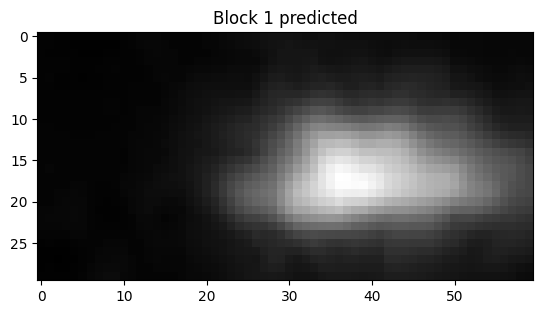

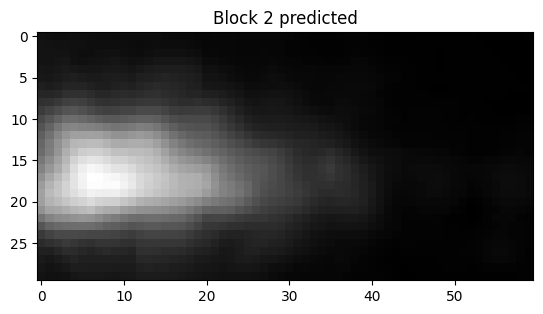

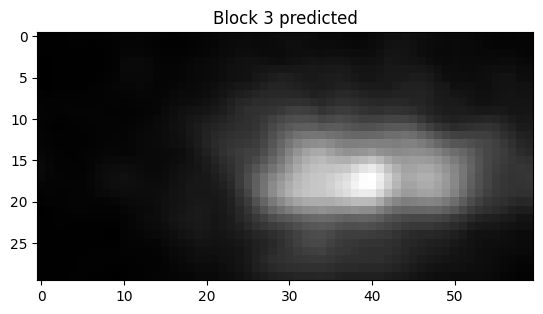

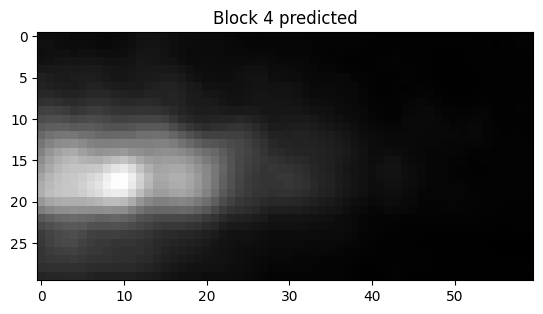

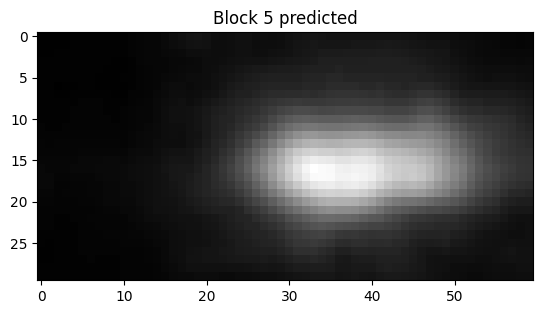

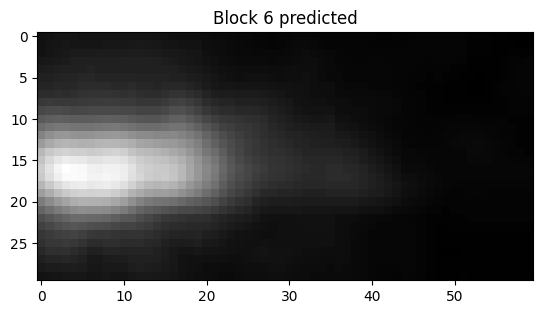

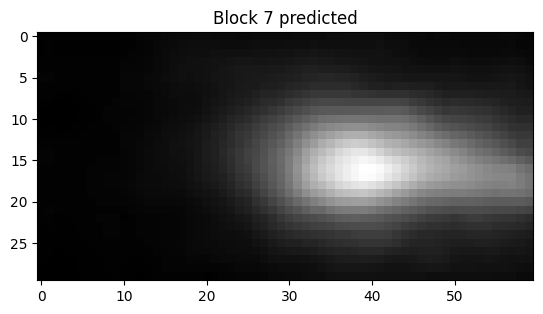

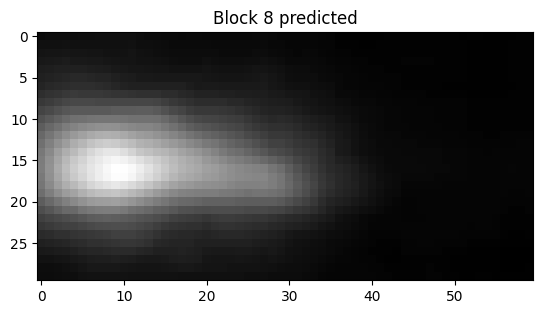

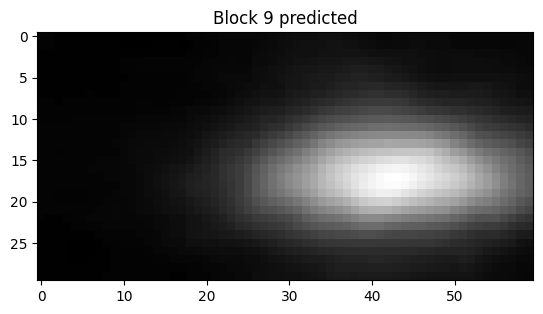

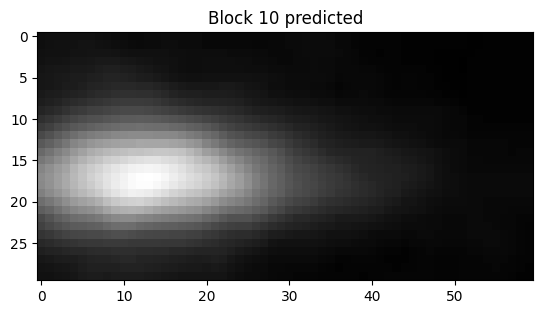

In [13]:
# show pulses predicted from test image
count = 0
for i in range(len(X_test)):
    if test_label[i]:
        count += 1
        plt.imshow(np.reshape(X_test[i], (30,60)), cmap="grey")
        plt.title("Block {} predicted".format(count))
        plt.show()

In [14]:
# find peak of laser pulse
def get_peak(block):
    # find peak values in each line for both x and y directions
    x_peaks = []
    for line in np.reshape(block, (30,60)):
        x_peaks.append(np.argmax(line))
    y_peaks = []
    for line in np.rot90(np.reshape(block, (30,60))):
        y_peaks.append(np.argmax(line))
    # retrieve coordinate of image peak
    x = stats.mode(x_peaks)[0]
    y = stats.mode(y_peaks)[0]
    return [x, y]

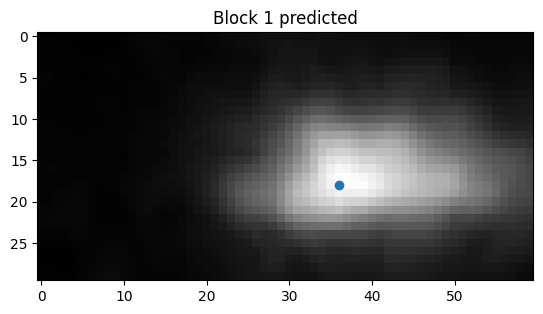

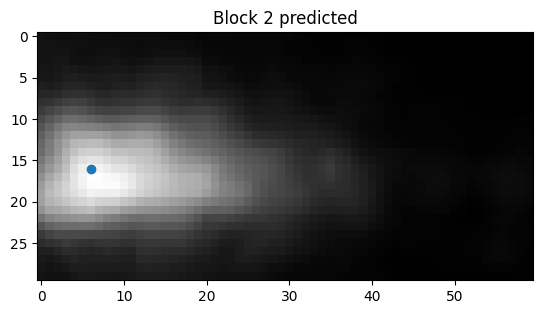

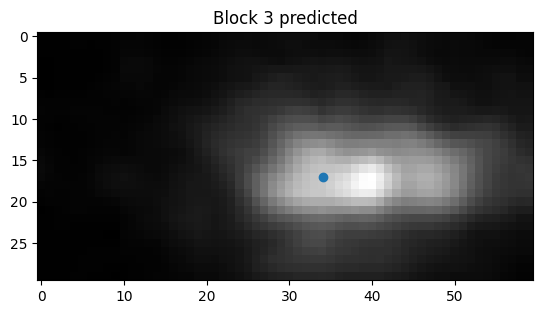

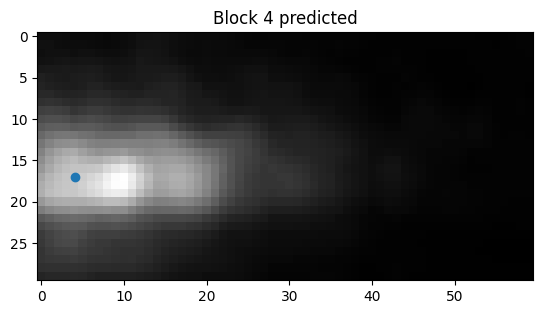

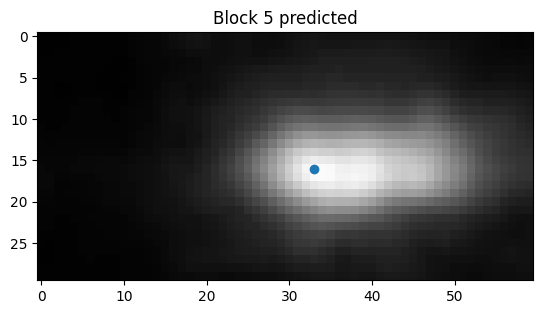

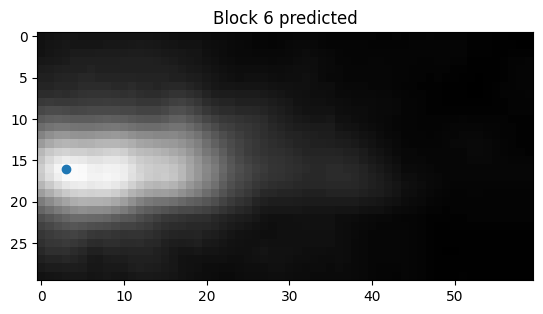

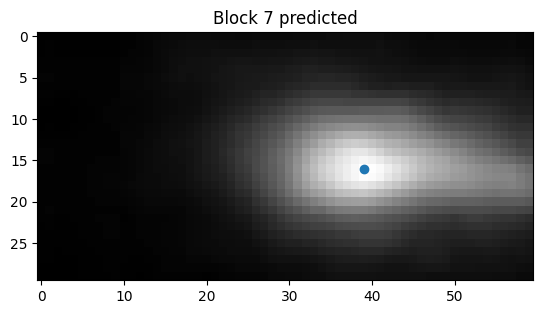

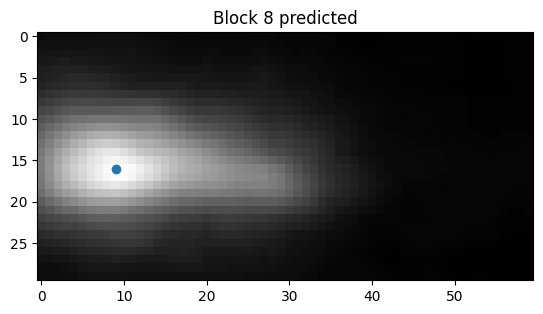

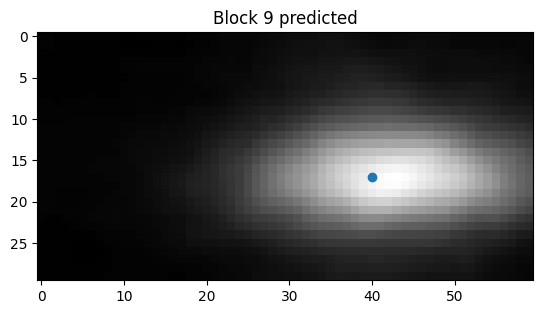

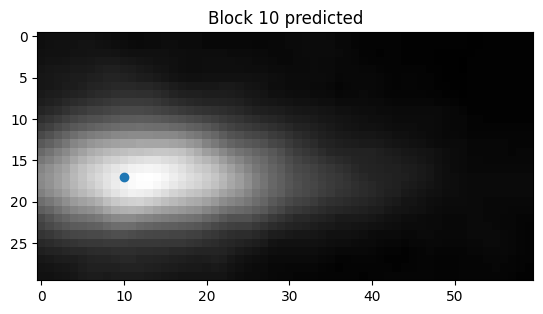

In [15]:
# show pulses predicted from test image
count = 0
for i in range(len(X_test)):
    if test_label[i]:
        count += 1
        plt.imshow(np.reshape(X_test[i], (30,60)), cmap="grey")
        plt.title("Block {} predicted".format(count))
        peak = get_peak(X_test[i])
        plt.scatter(peak[0], peak[1])
        plt.show()

Now that we have shown that we can find the peaks of the laser pulses, we can put them together on the test image.

In [16]:
# find coordinates of pulse peaks predicted in the test image
x_peaks = []
y_peaks = []
for i in range(len(X_test)):
    if test_label[i]:
        peak = get_peak(X_test[i])
        x_peaks.append(block_origin[i][1] + peak[0])
        y_peaks.append(block_origin[i][0] + peak[1])

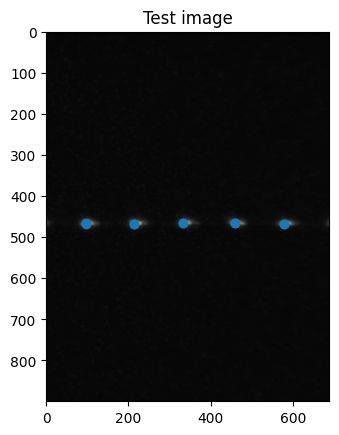

In [17]:
# show pulse peaks predicted in the test image
plt.imshow(test, cmap="grey")
plt.title("Test image")
plt.scatter(x_peaks, y_peaks)
plt.show()